# Turtle runs - RL with deep Q-learning

In [1]:
import sys
import math
import random
import numpy as np
from collections import namedtuple
from time import time

import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
actions = ['N', 'E', 'S', 'W', 'O']

In [3]:
class Turtle():
    def __init__(self, position, halite):
        self.position = position
        self.halite = halite

In [4]:
class GameState():
    def __init__(self, game_map, position, halite, turn):
        self.game_map = game_map
        self.position = position
        self.halite = halite
        self.turn = turn
        
    def __eq__(self, other):
        return (self.game_map == other.game_map).all() and self.position == other.position and self.halite == other.halite and self.turn == other.turn

    def get_nn_repr(self):
        hal_std_scaled = (self.game_map.reshape(-1,) - 500) / 1000
        pos_indicator = [0] * 25
        pos_indicator[self.position[0] * 5 + self.position[1]] = 1
        return np.array(list(hal_std_scaled) + pos_indicator + [self.halite / 1000, self.turn / 50])

In [5]:
class SimpleHalite():
    def __init__(self, height, width, start_pos):
        np.random.seed(42)
        self.game_map = np.random.randint(1, 1000, size=(height, width))
        self.game_map[start_pos] = 0
        self.orig_map = self.game_map.copy()
        self.turtle = Turtle(start_pos, 0)
        self.turn = 1
        self.max_turns = 50
        self.halite = 0
        self.base = start_pos
        self.height = height
        self.width = width
        self.actions = ['N', 'E', 'S', 'W', 'O']
    
    def get_state(self):
        game_state = GameState(self.game_map.copy(), self.turtle.position, self.turtle.halite, self.turn)
        return game_state.get_nn_repr()
    
    def get_possible_actions(self):
        return self.actions
    
    def reset(self):
        self.game_map = self.orig_map.copy()
        self.turtle = Turtle(self.base, 0)
        self.turn = 1
        self.halite = 0
        return self.get_state()
        
    def step(self, action):
        action = actions[action]
        reward = 0
        if action == 'O':
            mined_halite = min(1000 - self.turtle.halite, 
                               math.ceil(self.game_map[self.turtle.position] / 4))
            self.game_map[self.turtle.position] -= mined_halite
            self.turtle.halite += mined_halite
        else:
            if action == 'N':
                cost_halite = self.game_map[self.turtle.position] // 10
                new_pos = tuple([sum(x) for x in zip(self.turtle.position, (-1, 0))])
            elif action == 'E':
                cost_halite = self.game_map[self.turtle.position] // 10
                new_pos = tuple([sum(x) for x in zip(self.turtle.position, (0, 1))])
            elif action == 'S':
                cost_halite = self.game_map[self.turtle.position] // 10
                new_pos = tuple([sum(x) for x in zip(self.turtle.position, (1, 0))])
            elif action == 'W':
                cost_halite = self.game_map[self.turtle.position] // 10
                new_pos = tuple([sum(x) for x in zip(self.turtle.position, (0, -1))])
            #print(cost_halite, self.turtle.halite)
            if cost_halite <= self.turtle.halite:
                #print("moving turtle to {}".format(new_pos))
                self.turtle = Turtle(new_pos, self.turtle.halite - cost_halite)
            else:
                mined_halite = min(1000 - self.turtle.halite, 
                                   math.ceil(self.game_map[self.turtle.position] / 4))
                self.game_map[self.turtle.position] -= mined_halite
                self.turtle.halite += mined_halite
        self.turtle.position = (self.turtle.position[0] % self.width, 
                                self.turtle.position[1] % self.height)
        if self.turtle.position == self.base:
            self.halite += self.turtle.halite
            reward = self.turtle.halite
            self.turtle.halite = 0
        self.turn += 1
        #print("turn increment to {}".format(self.turn))
        return self.get_state(), reward, self.turn == self.max_turns

Needs to be a tuple rather than a list as start_pos

In [6]:
game = SimpleHalite(5, 5, (2, 2))

In [7]:
game.reset()

array([-0.397, -0.064,  0.361, -0.229, -0.393, -0.428,  0.201, -0.479,
        0.115, -0.378, -0.033, -0.285, -0.5  , -0.041, -0.412, -0.127,
       -0.4  ,  0.372,  0.164, -0.369,  0.162, -0.191,  0.27 , -0.156,
       -0.008,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.02 ])

## Q Learning 

In [8]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [9]:
class DQNAgent():
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            self.network = keras.models.Sequential()
            self.network.add(L.InputLayer(input_shape=state_shape))
            self.network.add(L.Dense(256, activation='relu'))
            self.network.add(L.Dense(256, activation='relu'))
            self.network.add(L.Dense(len(game.get_possible_actions())))

            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

            self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
            self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [10]:
def play_and_record(agent, game, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = game.get_state()
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done = game.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = game.reset()
        else:
            s = next_s
    return reward    

In [11]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

In [12]:
n_actions = len(game.get_possible_actions())
state_dim = (len(game.reset()),)
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
target_network = DQNAgent("target_network", state_dim, n_actions)
sess.run(tf.global_variables_initializer())

In [13]:
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [14]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [15]:
# compute q-values for NEXT states with target network
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph) 

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma * next_state_values_target * is_not_done

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
%matplotlib inline
mean_rw_history = []
td_loss_history = []

In [18]:
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [19]:
def evaluate(game, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = game.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done = game.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [21]:
exp_replay = ReplayBuffer(5*10**5)
play_and_record(agent, game, exp_replay, n_steps=10000)

64979.0

buffer size = 500000, epsilon = 0.40895


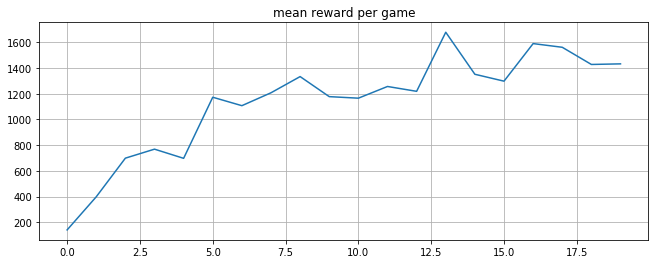

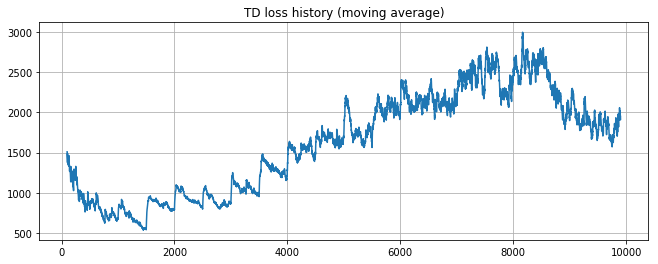

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:43<00:00, 11.32it/s]


In [22]:
for i in trange(10**4):
    # play
    play_and_record(agent, game, exp_replay, 100)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=128))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(SimpleHalite(5, 5, (2, 2)), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        #print("Current mean reward: {}".format(mean_rw_history[-1]))
        plt.figure(figsize=[24, 4])
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[24, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(DataFrame(td_loss_history).ewm(span=100, min_periods=100).mean())
        #plt.plot(pd.ewma(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [23]:
agent.network.save_weights('./turtle_5x5_dqn.hdf5')

In [28]:
evaluate(SimpleHalite(5, 5, (2, 2)), agent, n_games=10, greedy=False)

1720.9